In [33]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pint 
import pandas as pd
import seaborn as sns
from propeller_performance_parser import parse_propeller_performance
from scipy import optimize, interpolate, integrate

u = pint.UnitRegistry()

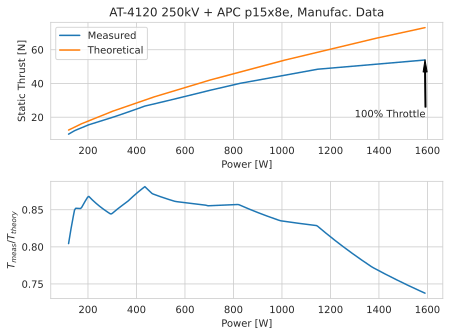

In [39]:
# engine performance
# propeller: APC 15x8E prop

p15x8e = pd.DataFrame(parse_propeller_performance('resources/PER3_15x8E.dat'))

df_m_0s = p15x8e[p15x8e['V (mph)'] == 0]

# plot thrust vs velocity graph
motor_text = """40%	44.32	2.70	119.63	3880	0.203	1012	8.46
45%	44.33	3.30	146.11	4287	0.248	1235	8.45
50%	44.30	4.56	201.83	4838	0.319	1574	7.80
55%	44.25	6.75	298.59	5422	0.411	2014	6.75
60%	44.23	8.19	362.23	5832	0.478	2331	6.43
65%	44.21	9.84	434.86	6243	0.558	2712	6.24
70%	44.14	12.69	560.11	6716	0.653	3146	5.62
75%	44.10	15.43	680.25	7132	0.749	3586	5.27
80%	44.04	18.63	820.64	7565	0.857	4067	4.96
90%	43.91	26.06	1144.20	8288	1.071	4934	4.31
100%	43.73	36.52	1596.93	8963	1.347	5504	3.45""".split("\n")

stats = np.array([[float(x) for x in l.split()[1:]] for l in motor_text ])
throttles = [l.split()[0] for l in motor_text]

names = """Throttle
Voltage (V)
Current (A)
Power (W)
RPM
Torque (N*m)
Thrust (g)
Efficiency (g/W)""".split("\n")[1:]

sns.set_style(style="whitegrid")

measured_T_P = interpolate.interp1d(x=stats[:, 2], y=stats[:, 5] * 9.81 * 1e-3, kind="linear")
theory_T_P = interpolate.interp1d(x=df_m_0s['PWR (W)'], y=df_m_0s['Thrust (N)'], kind="linear")
P = np.linspace(120, 1590,300)
measured_T = measured_T_P(P)
theory_T = theory_T_P(P)
efficiency = measured_T / theory_T

arrowprops = dict(
    color = "k",
    width = 1,
    headwidth = 4,
)

# compare the aerodynamically calculated shaft power to the electric power to the motor, manufacturer's data

ax0 = plt.subplot(211)
plt.plot(P, measured_T, label="Measured")
plt.plot(P, theory_T, label="Theoretical")

plt.xlabel("Power [W]")
plt.ylabel("Static Thrust [N]")
plt.legend()
plt.annotate("100% Throttle", xy=(1590, measured_T[-1]), xytext=(1300, 20), arrowprops=arrowprops)
plt.title("AT-4120 250kV + APC p15x8e, Manufac. Data")


plt.subplot(212, sharex=ax0)
plt.plot(P, efficiency)
plt.ylabel("$T_{meas} / T_{theory}$")
plt.xlabel("Power [W]")
plt.tight_layout()

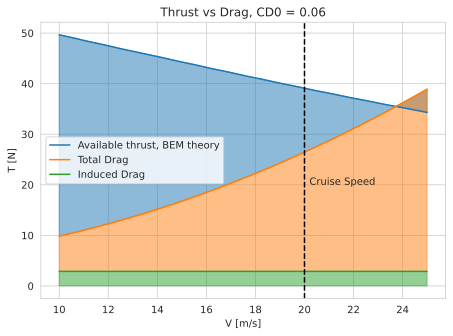

In [109]:
# takeoff calculations
eta = 0.75 # efficiency at full throttle

p15x8e['V (m/s)'] = p15x8e['V (mph)'] * (u('mph')/u('m/s')).to("").magnitude
points = np.array([p15x8e['rpm'].to_numpy(),
                  p15x8e['V (m/s)'].to_numpy()]).T
pe_theo = interpolate.LinearNDInterpolator(
    points = points,
    values = p15x8e['Pe -'],
)
P_theo = interpolate.LinearNDInterpolator(
    points = points,
    values = p15x8e['PWR (W)'],
)
T_theo = interpolate.LinearNDInterpolator(
    points = points,
    values = p15x8e['Thrust (N)'],
)
Q_P_theo = interpolate.LinearNDInterpolator(
    points = points,
    values = p15x8e['Torque (N-m)']
)

def rpm_theo(power, V):
    def rem(x):
        points = np.array([x, V]).T
        return P_theo(points) - power
    x0 = 8000 * np.ones_like(V)
    return optimize.fsolve(rem, x0)

def TP_theo(power, V):
    rpm = rpm_theo(power, V)
    points = np.array([rpm, V]).T
    return T_theo(points)

rho = 1.23
V = np.linspace(10, 25)
q = 1/2 * rho * V**2
W = 9.81 * 10
S = 1.5
CL = ((W / (q * S) )**0.5)
CD0 = 0.06
CD = CD0 + 0.044 * CL**2

P_avail = 1600
T_avail = P_avail * 0.75 * 0.7 / V
T_theor = TP_theo(P_avail * 0.75, V)
D = 1/2 * rho * V**2 * S * CD 
D_i = 1/2 * rho * V**2 * 0.044 * CL**2


# plt.plot(V_flight, P_required, label="Flight power required, CD = 0.04")
# plt.axhline(P_avail, color="k", linestyle="--")
# plt.plot(V, T_avail, label="Thrust avail, pe = 0.7")
plt.plot(V, T_theor, label="Available thrust, BEM theory")
plt.fill_between(V, D, T_theor, color="C0", alpha=0.5)
plt.plot(V, D, label="Total Drag")
plt.fill_between(V, D, D_i, color="C1", alpha=0.5)
plt.plot(V, D_i, label="Induced Drag")
plt.fill_between(V, np.zeros_like(D_i), D_i, color="C2", alpha=0.5)
# plt.plot(V, T_theo - D, label="Excess Thrust")
plt.axvline(20, color="k", linestyle="--")
plt.annotate("Cruise Speed", (20.2, 20))
plt.legend(loc="center left")
plt.xlabel("V [m/s]")
plt.ylabel("T [N]")
plt.title("Thrust vs Drag, CD0 = 0.06")
plt.tight_layout()

In [124]:
P_excess = (T_theor[34] - D[34]) * V[34]
# excess power = mg dh/dt
W = 8.2 * 9.81
print("Climb rate:", P_excess / W, "m/s")
rpm_20 = rpm_theo(1600 * 0.75, np.array([20]))[0]
pe = pe_theo(np.array([[8400, 20]]))
print(pe)

Climb rate: 2.867497509525219 m/s
[0.69060309]


Text(8600, 0.5, 'Operating point')

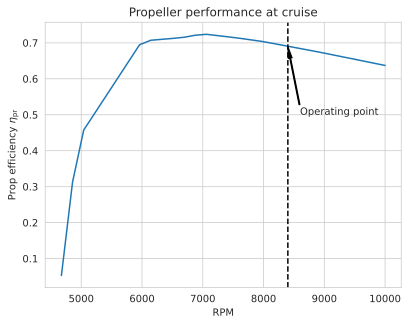

In [126]:
rpm_poss = np.linspace(1000, 10000)
points_20 = np.array([[rpm, 20] for rpm in rpm_poss])
pe_20 = pe_theo(points_20)
T_20 = T_theo(points_20)
# plt.subplot(211)
plt.plot(rpm_poss, pe_20)
plt.ylabel("Prop efficiency $\\eta_\\text{pr}$")
plt.title("Propeller performance at cruise")
# plt.subplot(212)
# plt.ylabel("Thrust [N]")
plt.xlabel("RPM")
plt.axvline(8400, linestyle="--", color="k")
plt.annotate("Operating point", (8400, 0.69), xytext=(8600, 0.5), arrowprops=dict(width=1, headwidth=4, color="k"))